In [2]:
from astropy.io import fits
from astropy.table import Table, Column, join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.convolution import Gaussian2DKernel,Tophat2DKernel,Gaussian1DKernel
from astropy.convolution import convolve, convolve_fft
from astropy.coordinates import SkyCoord
import glob
import os
from astropy.visualization import ZScaleInterval
import matplotlib.ticker as ticker

from matplotlib.gridspec import GridSpec
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)
from astropy.table import Table
import astropy.constants as const
import astropy.units as u
import numpy as np
from scipy.optimize import curve_fit
import re
from matplotlib.patches import Circle
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

def angular_to_physical_radius(theta_arcsec, redshift):

    ang_diameter_distance = cosmo.angular_diameter_distance(redshift)  # in Mpc
    theta_radian = (theta_arcsec * u.arcsec).to(u.rad).value  # Convert arcsec to radian
    physical_radius = ang_diameter_distance.to(u.kpc) * theta_radian  # Convert Mpc to kpc
    
    return physical_radius.value



# import sigma_clipping
from astropy.stats import sigma_clip,sigma_clipped_stats


plt.style.use('../paper.mplstyle')

Duplicate key in file '../paper.mplstyle', line 23 ('axes.linewidth : 1.5')


In [6]:
greenetab = Table.read('../literature_data/greene2020tab.csv')

In [4]:
greene20_sigma  = greenetab['σ∗']
greene20_sigmae = greenetab['Δσ∗']
greene20_MBH    = greenetab['MBH']
greene20_MBH_low= greenetab['ΔMBH']
greene20_MBH_up = greenetab['ΔMBH_1']
greene20_Mstar  = greenetab['M∗']

In [7]:
Maioline_2024_MBH =       np.array([7.5 , 7.25, 7.36, 6.82, 7.13, 7.3 , 7.71, 6.86, 7.22, 6.56, 7.69, 7.9, 6.2])
Maioline_2024_MBH_errup = np.array([0.31, 0.31, 0.32, 0.38, 0.31, 0.31, 0.3 , 0.35, 0.31, 0.32, 0.32, 0.3, 0.3])
Maioline_2024_MBH_errlow =np.array([0.31, 0.31, 0.12, 0.33, 0.31, 0.31, 0.3 , 0.34, 0.31, 0.31, 0.31, 0.3, 0.3])
Maioline_2024_logsigma =     np.array([1.93, 1.90, 1.95, 1.92, 1.96, 1.93, 1.64, 1.95, 1.85, 1.87, 1.77, 1.91, np.nan])
Maioline_2024_logsigma_errup=np.array([0.05, 0.06, 0.05, 0.06, 0.05, 0.06, 0.11, 0.06, 0.07, 0.07, 0.09, 0.06, np.nan])
Maioline_2024_logsigma_errlow=np.array([0.06, 0.07, 0.06, 0.06, 0.06, 0.07, 0.15, 0.07, 0.09, 0.08, 0.11, 0.06, np.nan])
Maioline_2024_Mstar =        np.array([8.88, 8.45, 8.34, 8.38, 7.79, 8.06, 9.78, 7.87, 8.11, 8.12, 10.18, 10.66, 8.9])
Maioline_2024_Mstar_errup =  np.array([0.66, 0.03, 0.20, 0.11, 0.3 , 0.7 , 0.2 , 0.16, 0.92, 0.12, 0.13,  0.09 , 0.2])
Maioline_2024_Mstar_errlow = np.array([0.66, 0.03, 0.20, 0.15, 0.3 , 0.7 , 0.2 , 0.28, 0.92, 0.13, 0.12,  0.1 , 0.3])
Maioline_2024_Mdyn =         np.array([9.23 ,8.84 ,np.nan,np.nan,9.81,np.nan,9.28,np.nan,8.92,9.27,np.nan,9.56,np.nan])
Maioline_2024_Mdyn_errup =   np.array([0.10 ,0.11 ,np.nan,np.nan,0.10,np.nan,0.21,np.nan,0.22,0.14,np.nan,0.13,np.nan])
Maioline_2024_Mdyn_errlow =  np.array([0.13 ,0.15 ,np.nan,np.nan,0.14,np.nan,0.41,np.nan,0.46,0.20,np.nan,0.18,np.nan])

# MBH 值（单位：Msun）
H24_MBH =           [3.2e7, 2.3e6, 3.7e6, 5.8e7, 1.9e7, 5.0e7, 4.2e7, 1.0e7, 9.8e7, 1.8e7]
H24_MBH_err_plus =  [0.3e7, 0.1e6, 0.2e6, 1.5e7, 0.8e7, 1.7e7, 1.2e7, 0.8e7, 4.4e7, 1.0e7]
H24_MBH_err_minus = [0.2e7, 0.1e6, 0.3e6, 1.3e7, 0.5e7, 1.3e7, 1.0e7, 0.5e7, 3.2e7, 0.6e7]
H24_logMstar =           [8.63, 8.82, 9.10, 9.11, 9.92, 9.01, 9.35, 9.36, 9.61, 8.94]
H24_logMstar_err_plus =  [0.63, None, 0.31, None, 0.51, None, None, 0.36, 0.77, 0.29]
H24_logMstar_err_minus = [1.03, None, 0.37, None, 0.68, None, None, 0.45, 1.18, 0.54]
# 将 MBH 转为 log10(MBH)
H24_logMBH = np.log10(H24_MBH)
H24_logMBH_err_plus = [np.log10(m + e) - np.log10(m) for m, e in zip(H24_MBH, H24_MBH_err_plus)]
H24_logMBH_err_minus = [np.log10(m) - np.log10(m - e) for m, e in zip(H24_MBH, H24_MBH_err_minus)]


KH13_bulges = Table.read('../literature_data/ar4-bulges.fits')
KH13_ellipticals = Table.read('../literature_data/ar4-ellipticals.fits')
KH13_bulges_Mdyn = KH13_bulges['col16']
KH13_bulges_Mdyn_err = KH13_bulges['col17']
KH13_bulges_sigma = KH13_bulges['col22']
KH13_bulges_sigma_err = KH13_bulges['col23']
KH13_bulges_MBH = KH13_bulges['col19']
KH13_bulges_MBH_eup = KH13_bulges['col20']
KH13_bulges_MBH_elow = KH13_bulges['col21']
KH13_ellipticals_Mdyn = KH13_ellipticals['col10']
KH13_ellipticals_Mdyn_err = KH13_ellipticals['col12']
KH13_ellipticals_sigma = KH13_ellipticals['col17']
KH13_ellipticals_sigma_err = KH13_ellipticals['col19']
KH13_ellipticals_MBH = KH13_ellipticals['col14']
KH13_ellipticals_MBH_eup = KH13_ellipticals['col15']
KH13_ellipticals_MBH_elow = KH13_ellipticals['col16']



In [10]:
# estimation of MBH upper limit of Narrow-line LRD
narrow_lrd_info = Table.read('../catalog/narrow_lrd_info.fits')
catalog_lrd = Table.read('../narrow_Ha_result_lsf_z2/LRD_spectral_catalog.csv')
lrdcigalefile = '../cigale_sed_fitting/out_LRD_250417/results.fits'
nar_lrd_host_result = Table.read('../cigale_sed_fitting/out_narlrd_hostcomp/results.fits')

lrdcigale_result = Table.read(lrdcigalefile)
narrowuidlist = [8219,12329,16321,20547,22015]

narrowlrdmask = [i in narrowuidlist for i in lrdcigale_result['id']]
narrowline_cigale = lrdcigale_result[narrowlrdmask]

mask = [i in narrowuidlist for i in catalog_lrd['source_id']]
narrowline_cat = catalog_lrd[mask]

EBV = narrowline_cigale['bayes.attenuation.E_BV_lines']
AV = EBV * 3.16
# AV = 1.5#EBV * 3.16

LHa_total = narrowline_cat['Ha_Luminosity_narrow_Ha1']*10**(0.4*AV)
LHa_total_err = narrowline_cat['Ha_Luminosity_err_narrow_Ha1']*10**(0.4*AV)
LHa_total_observed = narrowline_cat['Ha_Luminosity_narrow_Ha1']#*10**(0.4*AV)
LHa_total_err_observed = narrowline_cat['Ha_Luminosity_err_narrow_Ha1']#*10**(0.4*AV)
LHa_FWHM = np.array([136,292,475,272,229])#narrowline_cat['Ha_intrinsic_FWHM_narrow_Ha1'] #+ narrowline_cat['Ha_intrinsic_FWHM_narrow_err']
# print(LHa_total.value)
# print(LHa_FWHM.value)
LHa_FWHM_err = np.array([36,35,np.nan,64,36])#narrowline_cat['Ha_intrinsic_FWHM_narrow_Ha1']

#Greene & Ho 2005
MBH_narlrd = 2e6 * (LHa_total/1e42)**0.54 * (LHa_FWHM/1000)**2.06
MBH_err_narlrd = MBH_narlrd * np.sqrt((0.54*LHa_total_err/LHa_total)**2 + (2.06*LHa_FWHM_err/LHa_FWHM)**2)
log_MBH_narlrd = np.log10(MBH_narlrd)
log_MBH_err_narlrd_up = np.log10(MBH_narlrd + MBH_err_narlrd) - log_MBH_narlrd
log_MBH_err_narlrd_low = log_MBH_narlrd - np.log10(MBH_narlrd - MBH_err_narlrd)
# Reines 2013
log_MBH_narlrd_reines = np.log10(1.075) + 6.57 + 0.47*np.log10(LHa_total/1e42) + 2.06*np.log10(LHa_FWHM/1000)
log_MBH_narlrd_reines_observedHa = np.log10(1.075) + 6.57 + 0.47*np.log10(LHa_total_observed/1e42) + 2.06*np.log10(LHa_FWHM/1000)

m_star = narrowline_cigale['bayes.stellar.m_star']
logstellar_mass_narlrd = np.log10(m_star)
m_star_err = narrowline_cigale['bayes.stellar.m_star_err']
logstellar_mass_narlrd_up = np.log10(m_star + m_star_err) - logstellar_mass_narlrd
logstellar_mass_narlrd_low = logstellar_mass_narlrd - np.log10(m_star - m_star_err)

# star mass using the decomposed extended galaxy component
m_star_narhost = nar_lrd_host_result['bayes.stellar.m_star']
logstellar_mass_narlrd_host = np.log10(m_star_narhost)
m_star_narhost_err = nar_lrd_host_result['bayes.stellar.m_star_err']
logstellar_mass_narlrd_host_up = np.log10(m_star_narhost + m_star_narhost_err) - logstellar_mass_narlrd_host
logstellar_mass_narlrd_host_low = logstellar_mass_narlrd_host - np.log10(m_star_narhost - m_star_narhost_err)

# replace logstellar_mass_narlrd_low nan to 0.2
# cigale 有 lower limit 为 nan 的情况，这里用 0.2 代替, 需要更仔细的对待
logstellar_mass_narlrd_low = np.where(np.isnan(logstellar_mass_narlrd_low), 0.3, logstellar_mass_narlrd_low)


OIII_FWHM = np.array([196,117,np.nan,124,94])
OIII_FWHM_intrinsic_err = np.array([22,90,np.nan,111,87])  #narrowline_cat['OIII_intrinsic_FWHM_err']
OIII_FWHM_err = narrowline_cat['OIII_FWHM_err']
Ha_FWHM_narrow_Ha1 = narrowline_cat['Ha_intrinsic_FWHM_narrow_Ha1']
v_sigma = OIII_FWHM/2.355
v_sigma_err = OIII_FWHM_err/2.355
v_sigma_intrinsic_err = OIII_FWHM_intrinsic_err/2.355

/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_66904/2279268901.py:43: RuntimeWarning: invalid value encountered in log10
  logstellar_mass_narlrd_low = logstellar_mass_narlrd - np.log10(m_star - m_star_err)


In [11]:
log_MBH_narlrd_reines_observedHa

4.917972467700167
5.647019344688157
5.765346430968543
5.220339828999686
5.172288549222565


In [12]:
log_MBH_narlrd_reines_observedHa = [5.9, 6.0, 5.7, 5.6, 5.5]
log_MBH_narlrd_reines = [5.9, 6.0, 5.7, 5.6, 5.5]

In [13]:
log_MBH_narlrd_reines_observedHa = [5.9, 6.0, 5.8, 5.6, 5.5]
log_MBH_narlrd_reines = [5.9, 6.0, 5.8, 5.6, 5.5]

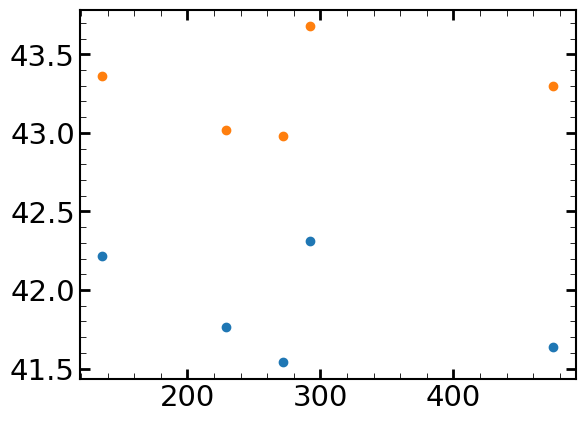

In [14]:
plt.scatter(LHa_FWHM, np.log10(LHa_total_observed))
plt.scatter(LHa_FWHM, np.log10(LHa_total))

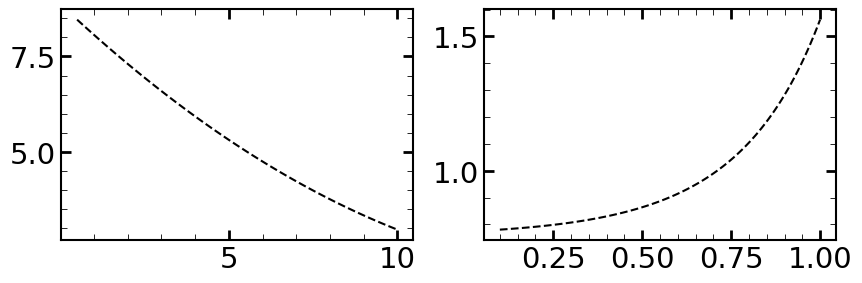

In [15]:
# dynamical mass

def Kn(n):
    return 8.87 - 0.831*n + 0.0241*n*n

def Kq(q):
    return (0.87 + 0.38*np.exp(-3.71*(1-q)))**2

n = np.linspace(0.5, 10, 100)
q = np.linspace(0.1, 1, 100)

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(n, Kn(n), color='black', linestyle='--')
ax2.plot(q, Kq(q), color='black', linestyle='--')

In [16]:
logstellar_mass_narlrd_host_low, logstellar_mass_narlrd_host_up

(<Column name='bayes.stellar.m_star' dtype='float64' unit='solMass' length=2>
 0.2613720979525551
 0.3616614301741725,
 <Column name='bayes.stellar.m_star' dtype='float64' unit='solMass' length=2>
 0.16202421655689303
 0.19455621687994995)

In [17]:
print(len(catalog_lrd))
print(len(catalog_lrd[catalog_lrd['Hb_EW'] > 0]))


32
20


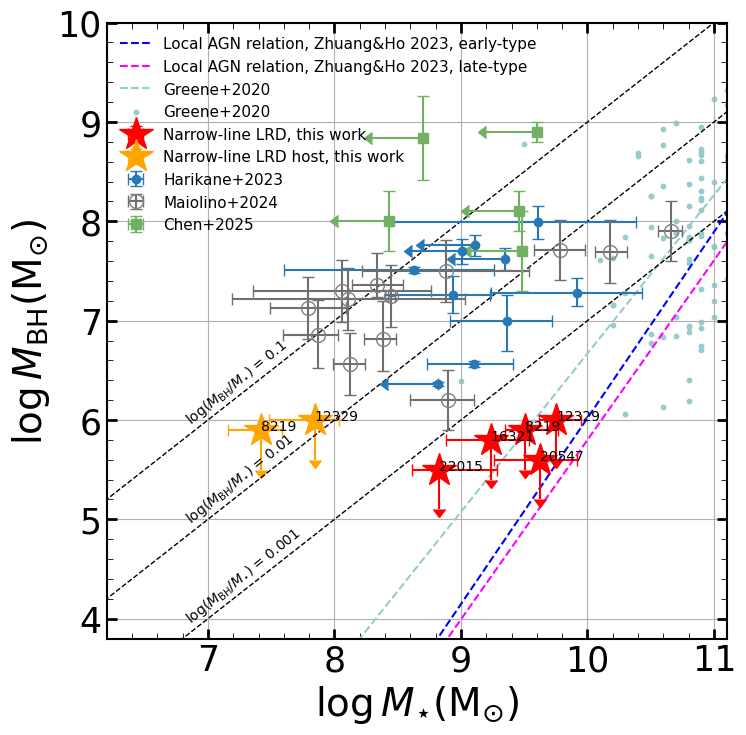

In [19]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

chen_gal_up = [8.43, 9.46, 8.70, 9.48, 9.60]
chen_bh_mass = [8.0, 8.1, 8.84, 7.7, 8.9]
chen_bh_mass_err = [0.3, 0.2, 0.42, 0.4, 0.1]

x = np.linspace(6, 12, 100)
y1 = 1.873 * x - 12.71    # 蓝色
y2 = 1.807 * x - 12.27    # 品红色
y3 = 1.595 * x - 9.28     # 棕红色
plt.plot(x, y1, label='Local AGN relation, Zhuang&Ho 2023, early-type', color='blue', linestyle='--')
plt.plot(x, y2, label='Local AGN relation, Zhuang&Ho 2023, late-type', color='magenta', linestyle='--')
# Narrow-line LRD
plt.errorbar(logstellar_mass_narlrd, log_MBH_narlrd_reines, xerr=[logstellar_mass_narlrd_up, logstellar_mass_narlrd_low], 
            yerr=[[0.4 for i in log_MBH_narlrd], [0 for i in log_MBH_narlrd]], uplims=[True for i in log_MBH_narlrd], fmt='*', color='red', label='Narrow-line LRD, this work', markersize=25, capsize=4, zorder = 50)
# Narrow-line LRD host
plt.errorbar(logstellar_mass_narlrd_host, log_MBH_narlrd_reines_observedHa[:2], xerr=[logstellar_mass_narlrd_host_low, logstellar_mass_narlrd_host_up], 
            yerr=[[0.4 for i in log_MBH_narlrd[:2]], [0 for i in log_MBH_narlrd[:2]]], uplims=[True for i in log_MBH_narlrd[:2]], fmt='*', color='orange', label='Narrow-line LRD host, this work', markersize=25, capsize=4)



# plt.plot(x, y3, label='Greene+2020', color='brown', linestyle='--')
plt.plot(x, y3, label='Greene+2020', color='#96CCCB', linestyle='--')
plt.scatter(greene20_Mstar, np.log10(greene20_MBH), color='#96CCCB', label='Greene+2020', marker='o', s=10)

# 画三条斜线
offsets = [np.log10(0.001), np.log10(0.01), np.log10(0.1)]
text = ['0.001', '0.01', '0.1']
for offset in offsets:
    plt.plot(x, x + offset, color='black', linestyle='--', lw=1)
# 沿斜线标记“温子”
for i, offset in enumerate(offsets):
    # 选择一个合适的位置，比如 x=5，对应 y=5 + offset
    x_text = 6.8
    y_text = x_text + offset + 0.12
    plt.text(x_text, y_text, r'$\log(M_{\rm BH}/M_{\star})$ = ' + text[i], rotation=39, fontsize=10,
             verticalalignment='bottom', horizontalalignment='left')

labels = False
# 遍历每个数据点，区分是否为上限
for i in range(len(H24_logMstar)):
    x = H24_logMstar[i]
    y = H24_logMBH[i]
    yerr = [[H24_logMBH_err_minus[i]], [H24_logMBH_err_plus[i]]]
    # 如果 logM* 误差为 None，画上限箭头
    if H24_logMstar_err_plus[i] is None:
        if(not labels):
            ax.errorbar(x, y, xerr = [0.4], yerr=yerr, fmt='o', color='#2878B5', xuplims=True, capsize=4, label='Harikane+2023')
            labels = True
        else:
            ax.errorbar(x, y, xerr = [0.4], yerr=yerr, fmt='o', color='#2878B5', xuplims=True, capsize=4)
        
    else:
        xerr = [[H24_logMstar_err_minus[i]], [H24_logMstar_err_plus[i]]]
        ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', color='#2878B5', capsize=4)


ax.errorbar(Maioline_2024_Mstar, Maioline_2024_MBH, xerr=[Maioline_2024_Mstar_errlow, Maioline_2024_Mstar_errup], markerfacecolor=(0, 0, 0, 0), markeredgecolor='gray',
            yerr=[Maioline_2024_MBH_errlow, Maioline_2024_MBH_errup], fmt='o', color='#6F6F6F', label='Maiolino+2024', markersize=10, capsize=4)
#chen 2025
ax.errorbar(chen_gal_up, chen_bh_mass,   xerr=[[0.4 for i in chen_bh_mass], [0 for i in chen_bh_mass]], xuplims=True,
            yerr=[chen_bh_mass_err, chen_bh_mass_err], fmt='s', color='#72B063', label='Chen+2025', markersize=7, capsize=4)


for i in range(len(catalog_lrd['source_id'][mask])):
    # if i == 2:
    #     continue
    plt.text(logstellar_mass_narlrd[i], log_MBH_narlrd_reines[i], catalog_lrd['source_id'][mask][i], fontsize=10, zorder = 60)
    if i < 2:
        plt.text(logstellar_mass_narlrd_host[i], log_MBH_narlrd_reines_observedHa[i], catalog_lrd['source_id'][mask][i], fontsize=10, zorder = 60)

plt.xlabel(r'$\log M_{\star} ({\rm M_{\odot}})$', fontsize=28)
plt.ylabel(r'$\log M_{\rm BH}({\rm M_{\odot})}$', fontsize=28)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
# plt.ylabel()

# plt.legend()
plt.grid(True)
plt.xlim(6.2, 11.1)
plt.ylim(3.8, 10)
plt.legend(loc='upper left', fontsize=11, frameon=False)
plt.savefig('../Figure/MBH_Mstar_relation.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
v_sigma_ori = OIII_FWHM/2.355
v_sigma_err = OIII_FWHM_err/2.355
v_sigma_intrinsic_err = OIII_FWHM_intrinsic_err/2.355

In [21]:
np.log10(v_sigma)




array([1.92026516, 1.69619495,        nan, 1.72143077, 1.60113694])

In [22]:
np.array( 0.047 * np.log10(LHa_total_observed) - 1.95)

array([0.03414739, 0.03869222, 0.00699491, 0.00237194, 0.0129619 ])

In [23]:
 np.array( 0.047 * np.log10(LHa_total) - 1.95)

array([0.0879521 , 0.10285386, 0.08509801, 0.06992505, 0.07194156])

In [24]:
v_sigma - v_sigma_intrinsic_err

array([73.88535032, 11.46496815,         nan,  5.52016985,  2.97239915])

In [25]:
np.log10(M_dyn_nalrd2.value)

NameError: name 'M_dyn_nalrd2' is not defined

/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_66904/3549018238.py:101: RuntimeWarning: invalid value encountered in log10
  xerr_lower = np.log10(M_dyn_nalrd.value) - np.log10(M_dyn_nalrd.value - M_err_measure.value)
/var/folders/gn/sbp9fx457qz90df4d6_4rsk80000gn/T/ipykernel_66904/3549018238.py:103: RuntimeWarning: invalid value encountered in log10
  xerr_intrinsic_lower = np.log10(M_dyn_nalrd.value) - np.log10(M_dyn_nalrd.value - M_err_intrinsic.value)


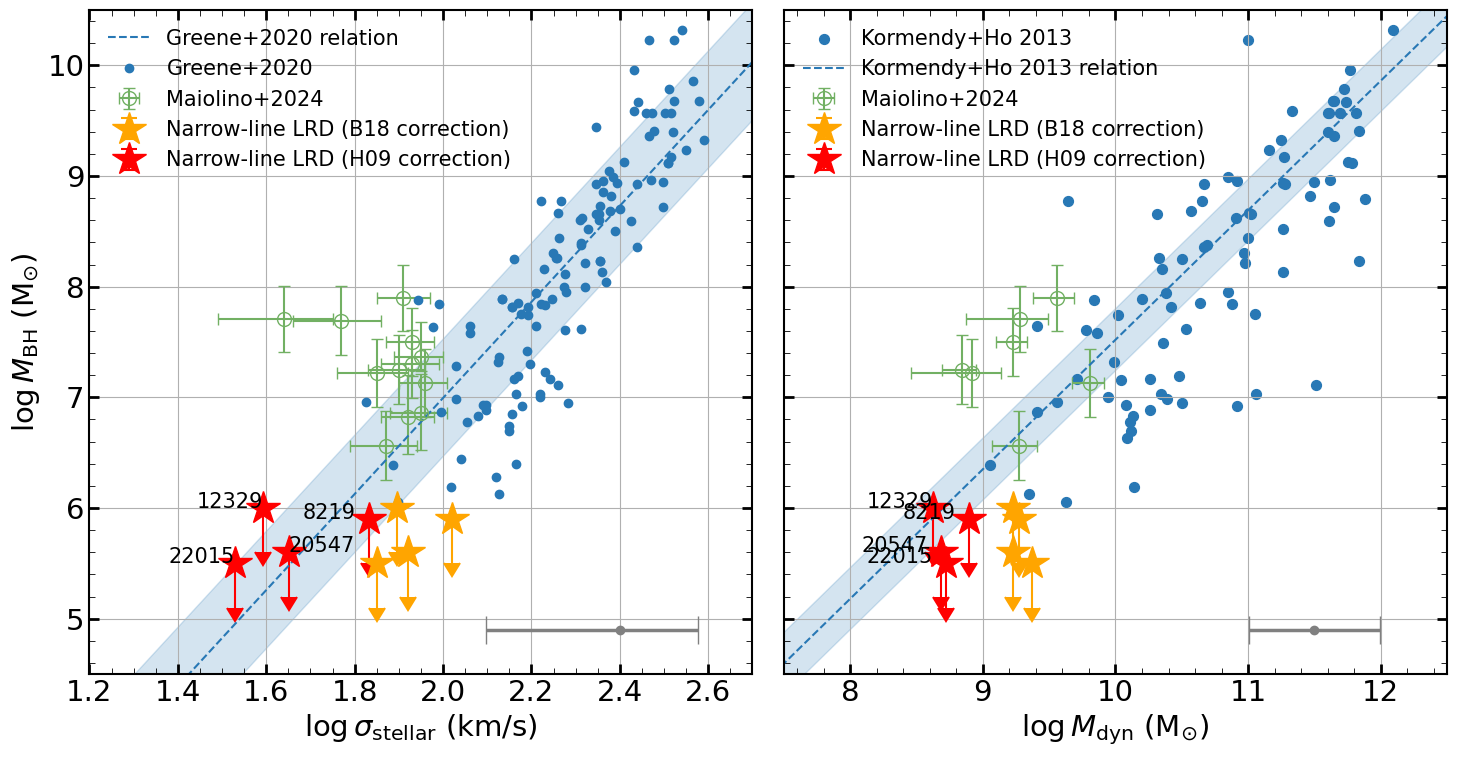

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Bezanson et al. (2018) correction, but samples are massive galaxy
corrector_factor1 = np.array([-0.1, -0.2, np.nan, -0.2, -0.25])
# Ho 2009 correction
corrector_factor2 =  np.array(0.047 * np.log10(LHa_total) - 1.95)


logvsigma_correct1 = np.log10(v_sigma_ori ) - corrector_factor1
v_sigma1 = 10**logvsigma_correct1
logvsigma_correct2 = np.log10(v_sigma_ori ) - corrector_factor2
v_sigma2 = 10**logvsigma_correct2

log_MBH_narlrd = log_MBH_narlrd_reines#np.log10(MBH_narlrd)
ax1.errorbar(np.log10(greene20_sigma), np.log10(greene20_MBH),        
             fmt='o', color='#2878B5', label='Greene+2020', markersize=6, capsize=4)
ax1.errorbar(Maioline_2024_logsigma, Maioline_2024_MBH, xerr=[Maioline_2024_logsigma_errlow, Maioline_2024_logsigma_errup],
            yerr=[Maioline_2024_MBH_errlow, Maioline_2024_MBH_errup], fmt='o',  markerfacecolor=(0, 0, 0, 0), markeredgecolor='#72B063', color ='#72B063',label='Maiolino+2024', markersize=10, capsize=4)
            #  fmt='o', color='#6F6F6F', label='Maiolino+2024', markersize=6, capsize=4)
            # 计算对数误差
safe_diff = np.maximum(v_sigma1 - v_sigma_intrinsic_err, 1)
xerr_lower = np.log10(v_sigma1) - np.log10(safe_diff)
xerr_upper = np.log10(v_sigma1 + v_sigma_intrinsic_err) - np.log10(v_sigma1)
ax1.errorbar(np.log10(v_sigma1), log_MBH_narlrd, #xerr=[xerr_lower, xerr_upper],#xerr=[np.log10(v_sigma) - np.log10(v_sigma - v_sigma_err), np.log10(v_sigma + v_sigma_err) - np.log10(v_sigma)], 
            yerr=[[0.4 for i in log_MBH_narlrd], [0 for i in log_MBH_narlrd]], uplims=[True for i in log_MBH_narlrd], fmt='*', color='orange', label='Narrow-line LRD (B18 correction)', markersize=25, capsize=6, capthick=1.5)
ax1.errorbar(np.log10(v_sigma2), log_MBH_narlrd, #xerr=[xerr_lower, xerr_upper],#xerr=[np.log10(v_sigma) - np.log10(v_sigma - v_sigma_err), np.log10(v_sigma + v_sigma_err) - np.log10(v_sigma)], 
            yerr=[[0.4 for i in log_MBH_narlrd], [0 for i in log_MBH_narlrd]], uplims=[True for i in log_MBH_narlrd], fmt='*', color='red', label='Narrow-line LRD (H09 correction)', markersize=25, capsize=6, capthick=1.5)
median_err_x_low = np.nanmedian(xerr_lower)
median_err_x_up = np.nanmedian(xerr_upper)
ax1.errorbar(2.4, 4.9, xerr = [[median_err_x_low], [median_err_x_up]],     fmt='o',
    ecolor='gray',
    color='gray',
    capsize=10,
    elinewidth=2.5    # ← 加粗误差棒
)
# plt.errorbar(np.log10(v_sigma), log_MBH_narlrd, xerr=[np.log10(v_sigma) - np.log10(v_sigma - v_sigma_intrinsic_err), np.log10(v_sigma + v_sigma_intrinsic_err) - np.log10(v_sigma)], 
#             yerr=[[0.4 for i in log_MBH_narlrd], [0 for i in log_MBH_narlrd]], uplims=[True for i in log_MBH_narlrd], fmt='*', color='red', markersize=25, capsize=4, linestyle='dashed')  


# 手动添加虚线误差棒和 cap
# for i in range(len(v_sigma)):
#     x = np.log10(v_sigma)[i]
#     y = log_MBH_narlrd[i]
#     ax1.plot([x - xerr_lower[i], x + xerr_upper[i]], [y, y], 'r--')  
#     ax1.plot([x - xerr_lower[i], x - xerr_lower[i]], [y - 0.08, y + 0.08], 'r')  # 左 cap
#     ax1.plot([x + xerr_upper[i], x + xerr_upper[i]], [y - 0.08, y + 0.08], 'r')  # 右 cap



x = np.linspace(10, 500, 100)
Greene_relation = 7.88 + 4.34*np.log10(x/160)

ax1.plot(np.log10(x), Greene_relation, label='Greene+2020 relation', color='#2878B5', linestyle='--')
# shaded region with scatter of 0.53
ax1.fill_between(np.log10(x), Greene_relation-0.53, Greene_relation+0.53, color='#2878B5', alpha=0.2)

ax1.set_xlim(1.2, 2.7)
ax1.set_ylim(4.5, 10.5)
ax1.set_xlabel(r'$\log \sigma_{\rm stellar}~(\rm km/s)$')
ax1.set_ylabel(r'$\log M_{\rm BH}~(\rm M_{\odot})$')
#set x major tick
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

ax1.legend(loc='upper left', fontsize=15, frameon=False)
ax1.grid(True)
v_sigma = v_sigma2
for i in range(len(catalog_lrd['source_id'][mask])):
    if i == 2:
        continue
    elif i == 3:
        ax1.text(np.log10(v_sigma)[i], log_MBH_narlrd[i], catalog_lrd['source_id'][mask][i], fontsize=15)
    else:
        ax1.text(np.log10(v_sigma)[i] - 0.15, log_MBH_narlrd[i], catalog_lrd['source_id'][mask][i], fontsize=15)
# plot Mdyn vs MBH


# adopt the galfit measurement in F150W band
z = np.array([6.785, 6.621, 5.2807,5.128875000000001])
n =  np.array([3.176, 0.537, 0.342, 2.590])
q =  np.array([0.804, 0.813, 0.101, 0.995])
Re_arc = np.array([3.395, 4.120, 5.169, 6.242])*0.03
Re = Re_arc*u.kpc
G = const.G
# log_MBH_narlrd = np.array([5.012084905929302, 5.871003506434436, 5.551100456895713, 5.255310242559744])
# log_MBH_narlrd = np.array([5.2484356952351, 6.0845064622428735, 5.79796927199449, 5.520449169312857])
# log_MBH_narlrd = np.array([5.458056516752645, 6.289738011632106,5.8979406584376415, 5.763256407621148])
# sigma = np.array([83.3, 49.702760084925686,52.9723991507431, 39.932059447983015])*u.km/u.s
log_MBH_narlrd = np.concatenate([log_MBH_narlrd_reines[:2], log_MBH_narlrd_reines[-2:]])
sigma1 = np.array(np.delete(v_sigma1,2))*u.km/u.s
sigma2 = np.array(np.delete(v_sigma2,2))*u.km/u.s

sigma_err = np.array([6.101910828025478, 6.492569002123142, 19.256900212314225, 9.779193205944798])*u.km/u.s
sigma_intrinsic_err = np.array([60.42038216560509, 42.41188959660297, 47.197452229299365, 37.13375796178344])*u.km/u.s
M_dyn_nalrd1 = (Kn(n)*Kq(q)*sigma1**2*Re/G).to(u.Msun)
M_dyn_nalrd2= (Kn(n)*Kq(q)*sigma2**2*Re/G).to(u.Msun)
# 计算误差传播
M_dyn_nalrd = M_dyn_nalrd2 
sigma = sigma2
M_err_measure = M_dyn_nalrd1 * np.sqrt((2 * sigma_err / sigma)**2)
M_err_intrinsic = M_dyn_nalrd * np.sqrt((2 * sigma_intrinsic_err / sigma)**2)
xerr_lower = np.log10(M_dyn_nalrd.value) - np.log10(M_dyn_nalrd.value - M_err_measure.value)
xerr_upper = np.log10(M_dyn_nalrd.value + M_err_measure.value) - np.log10(M_dyn_nalrd.value)
xerr_intrinsic_lower = np.log10(M_dyn_nalrd.value) - np.log10(M_dyn_nalrd.value - M_err_intrinsic.value)
xerr_intrinsic_upper = np.log10(M_dyn_nalrd.value + M_err_intrinsic.value) - np.log10(M_dyn_nalrd.value)
ln10 = np.log(10)
# 1. log 空间下的相对误差
logM_err_intrinsic = 2 * sigma_intrinsic_err / (sigma * ln10)



ax2.scatter(KH13_ellipticals_Mdyn, np.log10(KH13_ellipticals_MBH), color='#2878B5', label='Kormendy+Ho 2013', s=50)
ax2.scatter(KH13_bulges_Mdyn, np.log10(KH13_bulges_MBH), color='#2878B5', s=50)
# plot maiolino 2024
ax2.errorbar(Maioline_2024_Mdyn, Maioline_2024_MBH, xerr=[Maioline_2024_Mdyn_errlow, Maioline_2024_Mdyn_errup], 
            yerr=[Maioline_2024_MBH_errlow, Maioline_2024_MBH_errup], fmt='o',  markerfacecolor=(0, 0, 0, 0), markeredgecolor='#72B063', color ='#72B063',label='Maiolino+2024', markersize=10, capsize=4)

ax2.errorbar(np.log10(M_dyn_nalrd1.value), log_MBH_narlrd, yerr=[[0.4], [0]], uplims=[True], #xerr=[logM_err_intrinsic ,logM_err_intrinsic ], 
             fmt='*', color='orange', label='Narrow-line LRD (B18 correction)', markersize=25, capsize=6, capthick=1.5)
ax2.errorbar(np.log10(M_dyn_nalrd2.value), log_MBH_narlrd, yerr=[[0.4], [0]], uplims=[True], #xerr=[logM_err_intrinsic ,logM_err_intrinsic ], 
             fmt='*', color='red', label='Narrow-line LRD (H09 correction)', markersize=25, capsize=6, capthick=1.5)


median_err_x_low = np.nanmedian(xerr_intrinsic_upper)
ax2.errorbar(
    11.5, 4.9,
    xerr=[median_err_x_low],
    fmt='o',
    ecolor='gray',
    color='gray',
    capsize=10,
    elinewidth=2.5    # ← 加粗误差棒
)
# 手动添加虚线误差棒和 cap
# for i in range(len(M_dyn_nalrd)):
#     x = np.log10(M_dyn_nalrd.value)[i]
#     y = log_MBH_narlrd[i]
#     ax2.plot([x - xerr_intrinsic_lower[i], x + xerr_intrinsic_upper[i]], [y, y], 'r--')  
#     # ax2.plot([x - xerr_intrinsic_lower[i], x - xerr_intrinsic_lower[i]], [y - 0.08, y + 0.08], 'r')  # 左 cap
#     ax2.plot([x - xerr_intrinsic_lower[i], x + xerr_intrinsic_upper[i]], [y - 0.08, y + 0.08], 'r')  # 右 cap
# 手动添加虚线误差棒和 cap 2
# for i in range(len(M_dyn_nalrd)):
#     x = np.log10(M_dyn_nalrd.value)[i]
#     y = log_MBH_narlrd[i]
#     ax2.plot([x - logM_err_intrinsic[i], x + logM_err_intrinsic[i]], [y, y], 'r--')  
#     ax2.plot([x - logM_err_intrinsic[i], x - logM_err_intrinsic[i]], [y - 0.08, y + 0.08], 'r')  # 左 cap
#     ax2.plot([x + logM_err_intrinsic[i], x + logM_err_intrinsic[i]], [y - 0.08, y + 0.08], 'r')  # 右 cap

# 定义给定的关系式参数
a = 0.49  # 归一化因子
alpha = 1.17  # 斜率
err_a = [0.05, 0.06]  # 归一化因子的误差下限和上限
err_alpha = 0.08  # 斜率的误差

# 定义 M_bulge 范围（取对数）
M_bulge = np.logspace(7, 13, 100)  # M_bulge 取值范围
M_BH = a * (M_bulge / 1e11) ** alpha * 1e9  # 计算对应的 M_BH
ax2.plot(np.log10(M_bulge), np.log10(M_BH), label='Kormendy+Ho 2013 relation', color='#2878B5', linestyle='--')
ax2.fill_between(np.log10(M_bulge), np.log10(M_BH)-0.28, np.log10(M_BH)+0.28, color='#2878B5', alpha=0.2)

ax2.set_xlabel(r'$\log M_{\rm dyn}~(\rm M_{\odot})$')
# ax2.set_ylabel(r'$\log M_{\rm BH}~[\rm M_{\odot}]$')
ax2.legend(fontsize=15, frameon=False)
ax2.set_xlim(7.5, 12.5)
ax2.grid(True)
for i in range(len(catalog_lrd['source_id'][mask])):
    if i == 2:
        continue
    elif i > 2:
        ax2.text(np.log10(M_dyn_nalrd.value)[i-1] - 0.6, log_MBH_narlrd[i-1], catalog_lrd['source_id'][mask][i], fontsize=15)
    else:
        ax2.text(np.log10(M_dyn_nalrd.value)[i]- 0.5, log_MBH_narlrd[i], catalog_lrd['source_id'][mask][i], fontsize=15)

plt.tight_layout()

plt.savefig('../Figure/MBH_Mdyn_relation.pdf', dpi=300)